In [1]:
import os
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [921 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http:

In [3]:
#Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from google.colab import drive
drive.mount('/content/drive')

# Import Keras Dependencies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
 # Import findspark and initialize.
import findspark
findspark.init()

In [5]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weatherclassification").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [6]:
# Load in data
from pyspark import SparkFiles
url = 'https://weatherclassification.s3.amazonaws.com/weather_classification_data.csv'
spark.sparkContext.addFile(url)
print(SparkFiles.getRootDirectory())

spark_df = spark.read.csv(SparkFiles.get("weather_classification_data.csv"), sep=",", header=True, inferSchema=True)
spark_df.show()

/tmp/spark-a5441d39-71db-4e0a-bd96-811cad134c87/userFiles-e1a8308a-019c-4e9c-a138-062826dcd8f5
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|         14|      73|       9.5|               82|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|         39|      96|       8.5|               71|partly cloudy|             1011.43|       7|Spring|           10.0|  inland|      Cloudy|
|         30|      64|       7.0|               16|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|         38|      83|       1.5|               82|        

In [7]:
# Convert PySpark DataFrame to pandas DataFrame
weather_df = spark_df.toPandas()
weather_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [8]:
#Remove weather type
weather_data_no_type = weather_df.drop('Weather Type', axis=1)

In [9]:
# Convert categorical data to numeric with 'get_dummies'
weather_data_no_type = pd.get_dummies(weather_data_no_type).astype(int)
weather_data_no_type.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14,73,9,82,1010,2,3,0,0,0,1,0,0,0,1,0,1,0
1,39,96,8,71,1011,7,10,0,0,0,1,0,1,0,0,0,1,0
2,30,64,7,16,1018,5,5,1,0,0,0,0,1,0,0,0,0,1
3,38,83,1,82,1026,7,1,1,0,0,0,0,1,0,0,1,0,0
4,27,74,17,66,990,1,2,0,0,1,0,0,0,0,1,0,0,1


In [10]:
# Split our preprocessed data into our features and target arrays
X = weather_data_no_type
y = weather_df['Weather Type']

# Use LabelEncoder to convert categorical weather type labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = 4
y_one_hot = to_categorical(y_encoded, num_classes)

encoded_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)
label_mapping = dict(zip(encoded_labels, label_encoder.classes_))
print(f"Labels: {label_mapping}")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, random_state=1)

Labels: {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}


In [11]:
# Normalize Data
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Create function for model creation
def gen_model(units, activation_functions, input_dim, optimizer):
  # Define the deep learning model
  nn_model = tf.keras.models.Sequential()
  nn_model.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(len(units)):
    nn_model.add(tf.keras.layers.Dense(units=units[i], activation=activation_functions[i]))
  nn_model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return nn_model

In [13]:
# Model 1 Neurons [64, 32, 16, 8]
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_1 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_1.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_1_losses = []
model_loss, model_accuracy = nn_model_1.evaluate(X_test,y_test,verbose=2)

print(f"# Model 1 Neurons [64, 32, 16, 8] Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5501 - loss: 1.1423 - val_accuracy: 0.6798 - val_loss: 0.6825
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7146 - loss: 0.6237 - val_accuracy: 0.8601 - val_loss: 0.5014
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8552 - loss: 0.4731 - val_accuracy: 0.8818 - val_loss: 0.4006
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8727 - loss: 0.3955 - val_accuracy: 0.8747 - val_loss: 0.3663
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8826 - loss: 0.3323 - val_accuracy: 0.8939 - val_loss: 0.3055
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8959 - loss: 0.3047 - val_accuracy: 0.8904 - val_loss: 0.3012
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8955 - loss: 0.2890 - val_accuracy: 0.8960 - val_loss: 0.2772
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8988 - loss: 0.2823 - val_accuracy: 0.

In [14]:
# Make predictions using testing data
predictions = nn_model_1.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 1 Neurons [64, 32, 16, 8]')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model 1 Neurons [64, 32, 16, 8]")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix Model 1 Neurons [64, 32, 16, 8]
[[744  47  34  17]
 [ 36 744  44  22]
 [ 10  13 782  15]
 [ 33  18  27 714]]
Classification Report Model 1 Neurons [64, 32, 16, 8]
              precision    recall  f1-score   support

      Cloudy       0.90      0.88      0.89       842
       Rainy       0.91      0.88      0.89       846
       Snowy       0.88      0.95      0.92       820
       Sunny       0.93      0.90      0.92       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [15]:
# Get training and validation loss and accuracy values
nn_model_1_losses = fit_model.history['loss']
nn_model_1_accuracy = fit_model.history['accuracy']
nn_model_1_val_losses = fit_model.history['val_loss']
nn_model_1_val_accuracy = fit_model.history['val_accuracy']

In [16]:
# Model 2 Neurons [128, 64, 32, 16]
units = [128, 64, 32, 16]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_2 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_2.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_2_losses = []
model_loss, model_accuracy = nn_model_2.evaluate(X_test,y_test,verbose=2)

print(f"Model 2 Neurons [128, 64, 32, 16] Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6634 - loss: 0.9097 - val_accuracy: 0.8884 - val_loss: 0.4171
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8687 - loss: 0.4172 - val_accuracy: 0.8828 - val_loss: 0.3616
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8841 - loss: 0.3396 - val_accuracy: 0.8924 - val_loss: 0.3028
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8872 - loss: 0.3101 - val_accuracy: 0.8919 - val_loss: 0.2918
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8963 - loss: 0.2857 - val_accuracy: 0.9020 - val_loss: 0.2686
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9012 - loss: 0.2644 - val_accuracy: 0.9010 - val_loss: 0.2679
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9009 - loss: 0.2616 - val_accuracy: 0.8899 - val_loss: 0.2834
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8978 - loss: 0.2625 - val_accuracy: 0.

In [17]:
# Make predictions using testing data
predictions = nn_model_2.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 2 Neurons [128, 64, 32, 16]')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model 2 Neurons [128, 64, 32, 16]")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model 2 Neurons [128, 64, 32, 16]
[[740  43  16  43]
 [ 54 746  18  28]
 [ 15  19 762  24]
 [ 31  19   9 733]]
Classification Report Model 2 Neurons [128, 64, 32, 16]
              precision    recall  f1-score   support

      Cloudy       0.88      0.88      0.88       842
       Rainy       0.90      0.88      0.89       846
       Snowy       0.95      0.93      0.94       820
       Sunny       0.89      0.93      0.90       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [18]:
# Get training and validation loss and accuracy values
nn_model_2_losses = fit_model.history['loss']
nn_model_2_accuracy = fit_model.history['accuracy']
nn_model_2_val_losses = fit_model.history['val_loss']
nn_model_2_val_accuracy = fit_model.history['val_accuracy']

In [19]:
# Model 3 Neurons [256, 128, 64, 32]
units = [256, 128, 64, 32]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_3 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_3.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_3_losses = []
model_loss, model_accuracy = nn_model_3.evaluate(X_test,y_test,verbose=2)

print(f"Model 3 Neurons [256, 128, 64, 32] Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7162 - loss: 0.7894 - val_accuracy: 0.8783 - val_loss: 0.3785
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8773 - loss: 0.3681 - val_accuracy: 0.8879 - val_loss: 0.2882
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8851 - loss: 0.3086 - val_accuracy: 0.8980 - val_loss: 0.2571
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9013 - loss: 0.2618 - val_accuracy: 0.9025 - val_loss: 0.2467
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9073 - loss: 0.2508 - val_accuracy: 0.9056 - val_loss: 0.2504
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9048 - loss: 0.2451 - val_accuracy: 0.9040 - val_loss: 0.2323
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9010 - loss: 0.2433 - val_accuracy: 0.8874 - val_loss: 0.2586
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9092 - loss: 0.2279 - val_accuracy: 0.

In [20]:
# Make predictions using testing data
predictions = nn_model_3.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 3 Neurons [256, 128, 64, 32]')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model 3 Neurons [256, 128, 64, 32]")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model 3 Neurons [256, 128, 64, 32]
[[743  42  24  33]
 [ 65 738  24  19]
 [ 17  39 744  20]
 [ 26  15  23 728]]
Classification Report Model 3 Neurons [256, 128, 64, 32]
              precision    recall  f1-score   support

      Cloudy       0.87      0.88      0.88       842
       Rainy       0.88      0.87      0.88       846
       Snowy       0.91      0.91      0.91       820
       Sunny       0.91      0.92      0.91       792

    accuracy                           0.89      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.89      0.89      0.89      3300



In [21]:
# Get training and validation loss and accuracy values
nn_model_3_losses = fit_model.history['loss']
nn_model_3_accuracy = fit_model.history['accuracy']
nn_model_3_val_losses = fit_model.history['val_loss']
nn_model_3_val_accuracy = fit_model.history['val_accuracy']

In [22]:
# Model 4 Neurons [32, 64, 128, 256]
units = [32, 64, 128, 256]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_4 = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_4.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_4_losses = []
model_loss, model_accuracy = nn_model_4.evaluate(X_test,y_test,verbose=2)

print(f"Model 4 Neurons [32, 64, 128, 256]: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6807 - loss: 0.8760 - val_accuracy: 0.8677 - val_loss: 0.4801
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8635 - loss: 0.4252 - val_accuracy: 0.8869 - val_loss: 0.3329
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8886 - loss: 0.3265 - val_accuracy: 0.8803 - val_loss: 0.3211
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8918 - loss: 0.3025 - val_accuracy: 0.8914 - val_loss: 0.2761
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8852 - loss: 0.2911 - val_accuracy: 0.8955 - val_loss: 0.2649
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8995 - loss: 0.2652 - val_accuracy: 0.8980 - val_loss: 0.2498
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9024 - loss: 0.2506 - val_accuracy: 0.8934 - val_loss: 0.2608
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9055 - loss: 0.2496 - val_accuracy: 0.

In [23]:
# Make predictions using testing data
predictions = nn_model_4.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model 4 Neurons [32, 64, 128, 256]')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model 4 Neurons [32, 64, 128, 256]")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix Model 4 Neurons [32, 64, 128, 256]
[[755  37  17  33]
 [ 68 729  27  22]
 [ 18  11 770  21]
 [ 35  21  12 724]]
Classification Report Model 4 Neurons [32, 64, 128, 256]
              precision    recall  f1-score   support

      Cloudy       0.86      0.90      0.88       842
       Rainy       0.91      0.86      0.89       846
       Snowy       0.93      0.94      0.94       820
       Sunny       0.91      0.91      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [24]:
# Get training and validation loss and accuracy values
nn_model_4_losses = fit_model.history['loss']
nn_model_4_accuracy = fit_model.history['accuracy']
nn_model_4_val_losses = fit_model.history['val_loss']
nn_model_4_val_accuracy = fit_model.history['val_accuracy']

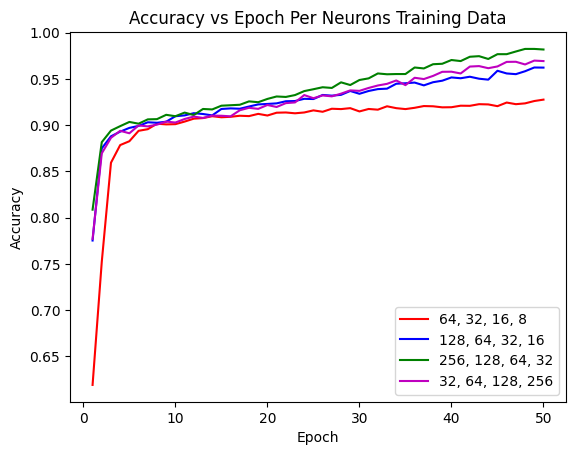

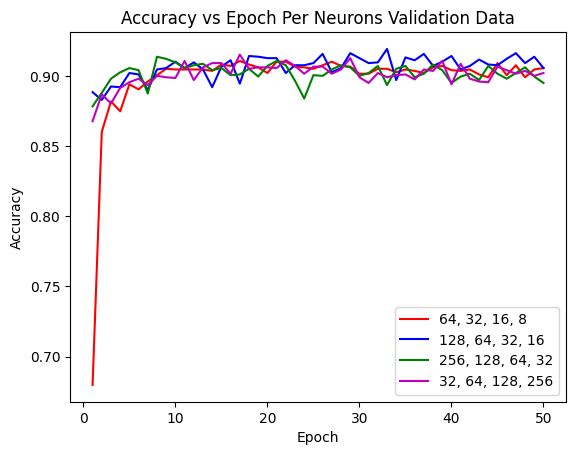

<Figure size 640x480 with 0 Axes>

In [25]:
# Plot accuracy for each neural network training and validation data attempts

#nn training accuracy data
epochs = range(1, len(nn_model_1_accuracy) + 1)

plt.plot(epochs, nn_model_1_accuracy, 'r', label = '64, 32, 16, 8')
plt.plot(epochs, nn_model_2_accuracy, 'b', label = '128, 64, 32, 16')
plt.plot(epochs, nn_model_3_accuracy, 'g', label = '256, 128, 64, 32')
plt.plot(epochs, nn_model_4_accuracy, 'm', label = '32, 64, 128, 256')

plt.title('Accuracy vs Epoch Per Neurons Training Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Training Data.png', format='png')

#nn validation accuracy data
epochs = range(1, len(nn_model_1_accuracy) + 1)

plt.plot(epochs, nn_model_1_val_accuracy, 'r', label = '64, 32, 16, 8')
plt.plot(epochs, nn_model_2_val_accuracy, 'b', label = '128, 64, 32, 16')
plt.plot(epochs, nn_model_3_val_accuracy, 'g', label = '256, 128, 64, 32')
plt.plot(epochs, nn_model_4_val_accuracy, 'm', label = '32, 64, 128, 256')

plt.title('Accuracy vs Epoch Per Neurons Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Validation Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Neurons Validation Data.png', format='png')

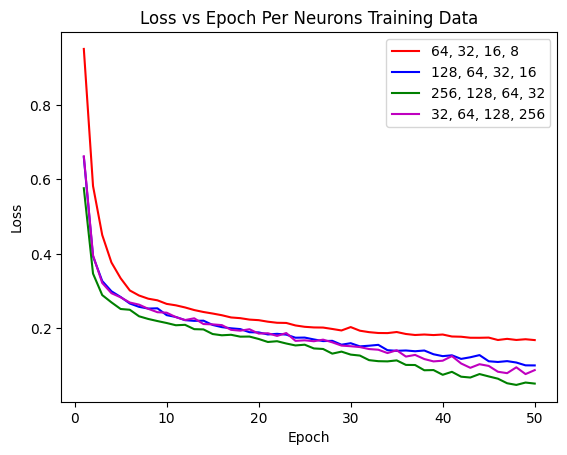

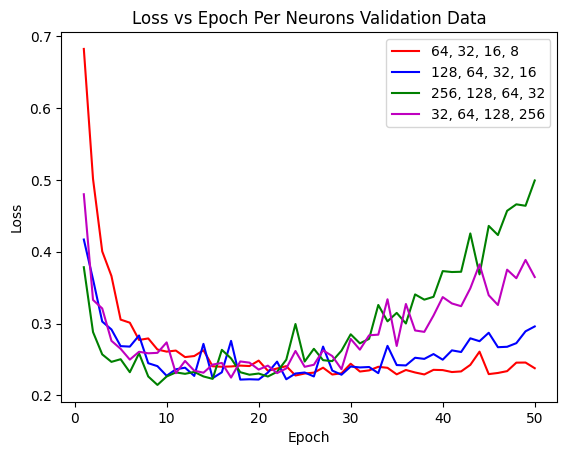

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot loss for each neural network training and validation data attempts

#nn training loss data
epochs = range(1, len(nn_model_1_losses) + 1)

plt.plot(epochs, nn_model_1_losses, 'r', label = '64, 32, 16, 8')
plt.plot(epochs, nn_model_2_losses, 'b', label = '128, 64, 32, 16')
plt.plot(epochs, nn_model_3_losses, 'g', label = '256, 128, 64, 32')
plt.plot(epochs, nn_model_4_losses, 'm', label = '32, 64, 128, 256')

plt.title('Loss vs Epoch Per Neurons Training Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Training Data.png', format='png')

#nn validation loss data
epochs = range(1, len(nn_model_1_losses) + 1)

plt.plot(epochs, nn_model_1_val_losses, 'r', label = '64, 32, 16, 8')
plt.plot(epochs, nn_model_2_val_losses, 'b', label = '128, 64, 32, 16')
plt.plot(epochs, nn_model_3_val_losses, 'g', label = '256, 128, 64, 32')
plt.plot(epochs, nn_model_4_val_losses, 'm', label = '32, 64, 128, 256')

plt.title('Loss vs Epoch Per Neurons Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Validation Data.png')


plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Neurons Validation Data.png', format='png')